In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
# from shapely.geometry import Point, box, LineString
from shapely import intersection
from tqdm.notebook import tqdm
import glob

target_epsg = 6350  # https://epsg.org/crs_6350/NAD83-2011-Conus-Albers.html?sessionkey=nb47agmo4r

In [2]:
fn_aoi = '/Volumes/Extreme SSD/largest_plots/clean_data/aoi.parquet'
fn_water_area_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/water_area_overlay.parquet'
dir_water_area = '/Volumes/Extreme SSD/largest_plots/raw_data/area_water/*.zip'

In [3]:
Aoi = gpd.read_parquet(fn_aoi).set_geometry('aoi').set_crs(epsg=target_epsg)

In [4]:
pattern_water_area = dir_water_area + '/*.zip'
fn_list_water_area = glob.glob(dir_water_area)


Iterate through each AOI x each water area file.
- Keep any rows that overlap at all with the AOI
- Each AOI's results will be stored as a list of geopandas tables.

In [5]:
intersection_list = []
for fn_water_area in tqdm(fn_list_water_area):
    WaterObservation = gpd.read_file(fn_water_area)
    WaterObservation = WaterObservation[['geometry']]
    WaterObservation = WaterObservation.rename(columns={'geometry':'water_area_geometry'})
    WaterObservation = WaterObservation.set_geometry('water_area_geometry').to_crs(epsg=target_epsg)
    Intersection = gpd.sjoin(left_df=WaterObservation, right_df=Aoi, how='inner', predicate='intersects', rsuffix='aoi')
    if len(Intersection) > 0:
        intersection_list.append(Intersection)
    else:
        pass

  0%|          | 0/3235 [00:00<?, ?it/s]

In [6]:
Intersection = pd.concat(intersection_list).reset_index(drop=True)

In [7]:
FlatIntersection = Intersection.dissolve(by='index_aoi')

In [8]:
FlatIntersection.head()

,water_area_geometry
index_aoi,
0,"MULTIPOLYGON (((1596080.360 1831118.615, 15960..."
1,"MULTIPOLYGON (((1570150.020 1778240.391, 15701..."
2,"MULTIPOLYGON (((874146.789 1167933.509, 874148..."
3,"MULTIPOLYGON (((590994.364 915385.518, 590985...."
4,"MULTIPOLYGON (((1027773.009 1664689.101, 10277..."


In [9]:
WaterAreaOverlay = FlatIntersection['water_area_geometry'].intersection(Aoi['aoi'], align=True)
WaterAreaOverlay = WaterAreaOverlay.to_frame().rename(columns={0:'water_area_geometry'})
WaterAreaOverlay = WaterAreaOverlay.set_geometry('water_area_geometry').set_crs(epsg=target_epsg)
WaterAreaOverlay.index.names = ['index']
WaterAreaOverlay.head()

,water_area_geometry
index,
0,"MULTIPOLYGON (((1596084.416 1831116.901, 15960..."
1,"MULTIPOLYGON (((1570154.497 1778239.313, 15701..."
2,"MULTIPOLYGON (((874148.571 1167932.453, 874155..."
3,"MULTIPOLYGON (((590948.857 915499.921, 591098...."
4,"MULTIPOLYGON (((1027771.879 1664683.992, 10277..."


In [10]:
WaterAreaOverlay.to_parquet(fn_water_area_overlay)

In [11]:
set(WaterAreaOverlay.index.values) == set(Aoi.index.values)

True

Iterate through the above dictionary, actually calculating the intersection between each AOI and the relevant water area polygons

# Manual QC fun:

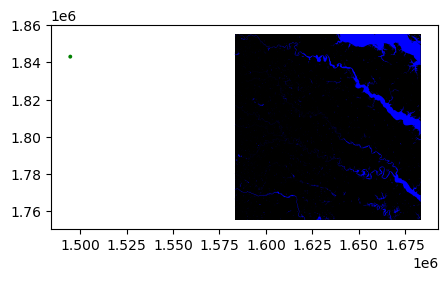

In [19]:
i = 210
fig, ax = plt.subplots(figsize=(5, 5))
# Aoi.loc[[i]].buffer(distance = 1e3*100).plot(ax=ax, alpha=0)
Aoi.loc[[i]].plot(ax=ax, color='black')
Intersection.loc[[i]].buffer(distance=1000).plot(ax=ax, color = 'green')
WaterAreaOverlay.loc[[i]].plot(ax=ax, color='blue')
plt.show()

# Save to disk

In [20]:
WaterAreaOverlay.to_parquet(fn_water_area_overlay)